# Modelagem Preditiva Com TensorFlow

Esse mini projeto é uma regressão linear simples feita com tensorflow, ou seja, desejamos encontrar uma estimação da função que ao ser inserdo o valor x, nos será retornado o valor y especificado.

In [1]:
#importando bibliotecas (básico para análise de dados)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#importando libs do tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Carregando dodos:

In [3]:
# Download dos dados
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
dataset_path = keras.utils.get_file("housing.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data")

In [4]:
# Nomes das colunas
nomes_colunas = ['CRIM',
                 'ZN',
                 'INDUS',
                 'CHAS',
                 'NOX',
                 'RM', 
                 'AGE', 
                 'DIS',
                 'RAD',
                 'TAX',
                 'PTRATION', 
                 'B', 
                 'LSTAT', 
                 'MEDV']

In [5]:
#carrega dados em um dataset pandas
dataset = pd.read_csv(dataset_path, 
                      names = nomes_colunas,
                      na_values = "?", 
                      comment = '\t',
                      sep = " ", 
                      skipinitialspace = True)

In [6]:
#exibindo linhas iniciais do dataframe:
dataset.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATION,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [7]:
#Verificando numero de colunas, linhas, tipo de dados e valores nulos
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   CRIM      506 non-null    float64
 1   ZN        506 non-null    float64
 2   INDUS     506 non-null    float64
 3   CHAS      506 non-null    int64  
 4   NOX       506 non-null    float64
 5   RM        506 non-null    float64
 6   AGE       506 non-null    float64
 7   DIS       506 non-null    float64
 8   RAD       506 non-null    int64  
 9   TAX       506 non-null    float64
 10  PTRATION  506 non-null    float64
 11  B         506 non-null    float64
 12  LSTAT     506 non-null    float64
 13  MEDV      506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


<AxesSubplot:xlabel='MEDV', ylabel='Count'>

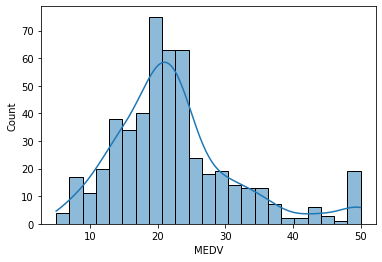

In [8]:
#plotando a distribuição da váriavel target
sns.histplot(data=dataset, x='MEDV', kde=True)

## Regressão Linear Simples

Para essa regressão, usaremos apenas a váriavel RM e MEDV, que foi o proposto no caso de estudo, mas que apresenta uma clara ligação linear como podemos ver no grafico de disperção abaixo.

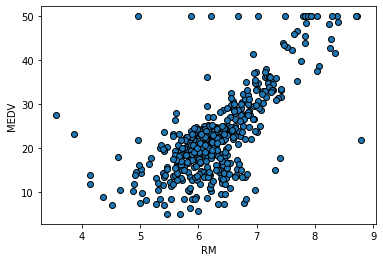

In [9]:
fig, ax = plt.subplots()
x= dataset['RM'].copy()
y= dataset['MEDV'].copy()
ax.scatter(x,y, edgecolors=(0,0,0))
ax.set_xlabel('RM')
ax.set_ylabel('MEDV');

In [10]:
#Dividindo o dataset em treino e teste:
from sklearn.model_selection import train_test_split
X_treino, X_teste, y_treino, y_teste = train_test_split(dataset['RM'],dataset['MEDV'], test_size=0.20, random_state=42)

Como dito acima, desejamos encontar o alpha e o beta de uma função matemática, numa função que seja f(x) = ax+b, o que estamos procurando é o valor de a e b, já que possuímos os valores de x e y. Atráves desse padrão, podemos fazer estimativas do valor y inserindo um novo valor x:

In [11]:
#Função para construir o modelo
def modelo_linear():
    model= keras.Sequential([layers.Dense(1, use_bias=True, input_shape=(1,), name='layer')])
    
    optimizer= tf.keras.optimizers.Adam(learning_rate = 0.01,
                                       beta_1=0.9,
                                       beta_2=0.99,
                                       epsilon= 1e-05,
                                       amsgrad= False,
                                       name='Adam')
    model.compile(loss= 'mse',
                 optimizer= optimizer,
                 metrics= ['mae', 'mse'])
    
    return model

In [12]:
#cria o modelo
modelo = modelo_linear()

In [13]:
modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer (Dense)               (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


## Treinamento do modelo:

In [14]:
#hiperparâmetros
n_epochs = 4000
batch_size = 256
n_idle_epochs = 100
n_epochs_log = 200
n_samples_save= n_epochs_log * X_treino.shape[0]
print('Checkpoint salvo a cada {} amostras'.format(n_samples_save))

Checkpoint salvo a cada 80800 amostras


In [15]:
#callBack
earlyStopping= tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = n_idle_epochs,
                                               min_delta = 0.01)

In [16]:
#lista para as previsões
predicions_list = []

In [17]:
#caminho para salver os checkpoint
checkpoint_path = "dados/"

In [18]:
#criando o callback que salva o modelo os valores do modelo a cada n_samples_save
checkpointCallback = tf.keras.callbacks.ModelCheckpoint(filepath = "dados/", 
                                                        verbose = 1, 
                                                        save_weights_only = True,
                                                        save_freq = n_samples_save)

In [19]:
# Salva a primeira versão do modelo
modelo.save_weights(checkpoint_path.format(epoch = 0))

In [20]:
# Treinamento
history = modelo.fit(X_treino, 
                     y_treino, 
                     batch_size = batch_size,
                     epochs = n_epochs, 
                     validation_split = 0.1, 
                     verbose = 1, 
                     callbacks = [earlyStopping, checkpointCallback])

Epoch 1/4000
2/2 [==============================] - 0s 97ms/step - loss: 328.3457 - mae: 15.8167 - mse: 328.3457 - val_loss: 319.3174 - val_mae: 15.9563 - val_mse: 319.3174
Epoch 2/4000
2/2 [==============================] - 0s 15ms/step - loss: 323.4970 - mae: 15.6744 - mse: 323.4970 - val_loss: 314.5981 - val_mae: 15.8116 - val_mse: 314.5981
Epoch 3/4000
2/2 [==============================] - 0s 15ms/step - loss: 318.7361 - mae: 15.5321 - mse: 318.7361 - val_loss: 309.9116 - val_mae: 15.6666 - val_mse: 309.9116
Epoch 4/4000
2/2 [==============================] - 0s 15ms/step - loss: 314.0871 - mae: 15.3906 - mse: 314.0871 - val_loss: 305.2649 - val_mae: 15.5215 - val_mse: 305.2649
Epoch 5/4000
2/2 [==============================] - 0s 15ms/step - loss: 309.4758 - mae: 15.2493 - mse: 309.4758 - val_loss: 300.6683 - val_mae: 15.3766 - val_mse: 300.6683
Epoch 6/4000
2/2 [==============================] - 0s 14ms/step - loss: 304.8389 - mae: 15.1076 - mse: 304.8389 - val_loss: 296.1247 -

2/2 [==============================] - 0s 15ms/step - loss: 159.9430 - mae: 10.0072 - mse: 159.9430 - val_loss: 152.5585 - val_mae: 9.9229 - val_mse: 152.5585
Epoch 49/4000
2/2 [==============================] - 0s 14ms/step - loss: 157.5757 - mae: 9.9120 - mse: 157.5757 - val_loss: 150.1960 - val_mae: 9.8209 - val_mse: 150.1960
Epoch 50/4000
2/2 [==============================] - 0s 14ms/step - loss: 155.2360 - mae: 9.8181 - mse: 155.2360 - val_loss: 147.8812 - val_mae: 9.7197 - val_mse: 147.8812
Epoch 51/4000
2/2 [==============================] - 0s 15ms/step - loss: 152.9140 - mae: 9.7247 - mse: 152.9140 - val_loss: 145.6076 - val_mae: 9.6191 - val_mse: 145.6076
Epoch 52/4000
2/2 [==============================] - 0s 15ms/step - loss: 150.7165 - mae: 9.6317 - mse: 150.7165 - val_loss: 143.3676 - val_mae: 9.5188 - val_mse: 143.3676
Epoch 53/4000
2/2 [==============================] - 0s 15ms/step - loss: 148.4684 - mae: 9.5393 - mse: 148.4684 - val_loss: 141.1723 - val_mae: 9.4193 -

2/2 [==============================] - 0s 14ms/step - loss: 85.8335 - mae: 6.7773 - mse: 85.8335 - val_loss: 78.3038 - val_mae: 6.2966 - val_mse: 78.3038
Epoch 97/4000
2/2 [==============================] - 0s 15ms/step - loss: 84.9613 - mae: 6.7356 - mse: 84.9613 - val_loss: 77.4632 - val_mae: 6.2479 - val_mse: 77.4632
Epoch 98/4000
2/2 [==============================] - 0s 14ms/step - loss: 84.1939 - mae: 6.6978 - mse: 84.1939 - val_loss: 76.6406 - val_mae: 6.1994 - val_mse: 76.6406
Epoch 99/4000
2/2 [==============================] - 0s 15ms/step - loss: 83.3684 - mae: 6.6579 - mse: 83.3684 - val_loss: 75.8445 - val_mae: 6.1517 - val_mse: 75.8445
Epoch 100/4000
2/2 [==============================] - 0s 14ms/step - loss: 82.6189 - mae: 6.6193 - mse: 82.6189 - val_loss: 75.0628 - val_mae: 6.1040 - val_mse: 75.0628
Epoch 101/4000
2/2 [==============================] - 0s 15ms/step - loss: 81.8980 - mae: 6.5842 - mse: 81.8980 - val_loss: 74.3014 - val_mae: 6.0587 - val_mse: 74.3014
Epoc

2/2 [==============================] - 0s 15ms/step - loss: 64.8445 - mae: 5.7148 - mse: 64.8445 - val_loss: 56.4908 - val_mae: 4.9602 - val_mse: 56.4908
Epoch 145/4000
2/2 [==============================] - 0s 16ms/step - loss: 64.6822 - mae: 5.7091 - mse: 64.6822 - val_loss: 56.3260 - val_mae: 4.9509 - val_mse: 56.3260
Epoch 146/4000
2/2 [==============================] - 0s 15ms/step - loss: 64.5477 - mae: 5.7059 - mse: 64.5477 - val_loss: 56.1643 - val_mae: 4.9416 - val_mse: 56.1643
Epoch 147/4000
2/2 [==============================] - 0s 15ms/step - loss: 64.4224 - mae: 5.7026 - mse: 64.4224 - val_loss: 56.0096 - val_mae: 4.9327 - val_mse: 56.0096
Epoch 148/4000
2/2 [==============================] - 0s 14ms/step - loss: 64.2943 - mae: 5.6991 - mse: 64.2943 - val_loss: 55.8653 - val_mae: 4.9263 - val_mse: 55.8653
Epoch 149/4000
2/2 [==============================] - 0s 20ms/step - loss: 64.1648 - mae: 5.6967 - mse: 64.1648 - val_loss: 55.7306 - val_mae: 4.9220 - val_mse: 55.7306
E

2/2 [==============================] - 0s 15ms/step - loss: 62.2496 - mae: 5.7396 - mse: 62.2496 - val_loss: 53.3315 - val_mae: 4.9046 - val_mse: 53.3315
Epoch 193/4000
2/2 [==============================] - 0s 16ms/step - loss: 62.2398 - mae: 5.7415 - mse: 62.2398 - val_loss: 53.3146 - val_mae: 4.9072 - val_mse: 53.3146
Epoch 194/4000
2/2 [==============================] - 0s 15ms/step - loss: 62.2301 - mae: 5.7435 - mse: 62.2301 - val_loss: 53.2986 - val_mae: 4.9096 - val_mse: 53.2986
Epoch 195/4000
2/2 [==============================] - 0s 14ms/step - loss: 62.2205 - mae: 5.7450 - mse: 62.2205 - val_loss: 53.2832 - val_mae: 4.9120 - val_mse: 53.2832
Epoch 196/4000
2/2 [==============================] - 0s 15ms/step - loss: 62.2092 - mae: 5.7467 - mse: 62.2092 - val_loss: 53.2675 - val_mae: 4.9145 - val_mse: 53.2675
Epoch 197/4000
2/2 [==============================] - 0s 14ms/step - loss: 62.2129 - mae: 5.7500 - mse: 62.2129 - val_loss: 53.2511 - val_mae: 4.9172 - val_mse: 53.2511
E

2/2 [==============================] - 0s 15ms/step - loss: 62.0369 - mae: 5.7660 - mse: 62.0369 - val_loss: 53.0511 - val_mae: 4.9347 - val_mse: 53.0511
Epoch 241/4000
2/2 [==============================] - 0s 15ms/step - loss: 62.0330 - mae: 5.7656 - mse: 62.0330 - val_loss: 53.0495 - val_mae: 4.9342 - val_mse: 53.0495
Epoch 242/4000
2/2 [==============================] - 0s 14ms/step - loss: 62.0291 - mae: 5.7651 - mse: 62.0291 - val_loss: 53.0478 - val_mae: 4.9337 - val_mse: 53.0478
Epoch 243/4000
2/2 [==============================] - 0s 14ms/step - loss: 62.0252 - mae: 5.7646 - mse: 62.0252 - val_loss: 53.0464 - val_mae: 4.9331 - val_mse: 53.0464
Epoch 244/4000
2/2 [==============================] - 0s 15ms/step - loss: 62.0212 - mae: 5.7640 - mse: 62.0212 - val_loss: 53.0458 - val_mae: 4.9323 - val_mse: 53.0458
Epoch 245/4000
2/2 [==============================] - 0s 14ms/step - loss: 62.0172 - mae: 5.7632 - mse: 62.0172 - val_loss: 53.0460 - val_mae: 4.9313 - val_mse: 53.0460
E

2/2 [==============================] - 0s 14ms/step - loss: 61.8034 - mae: 5.7587 - mse: 61.8034 - val_loss: 52.8772 - val_mae: 4.9266 - val_mse: 52.8772
Epoch 289/4000
2/2 [==============================] - 0s 15ms/step - loss: 61.7965 - mae: 5.7555 - mse: 61.7965 - val_loss: 52.8816 - val_mae: 4.9239 - val_mse: 52.8816
Epoch 290/4000
2/2 [==============================] - 0s 15ms/step - loss: 61.7896 - mae: 5.7530 - mse: 61.7896 - val_loss: 52.8844 - val_mae: 4.9217 - val_mse: 52.8844
Epoch 291/4000
2/2 [==============================] - 0s 15ms/step - loss: 61.7860 - mae: 5.7509 - mse: 61.7860 - val_loss: 52.8869 - val_mae: 4.9196 - val_mse: 52.8869
Epoch 292/4000
2/2 [==============================] - 0s 14ms/step - loss: 61.7814 - mae: 5.7491 - mse: 61.7814 - val_loss: 52.8867 - val_mae: 4.9183 - val_mse: 52.8867
Epoch 293/4000
2/2 [==============================] - 0s 14ms/step - loss: 61.7746 - mae: 5.7479 - mse: 61.7746 - val_loss: 52.8837 - val_mae: 4.9177 - val_mse: 52.8837
E

2/2 [==============================] - 0s 14ms/step - loss: 61.4781 - mae: 5.7475 - mse: 61.4781 - val_loss: 52.6162 - val_mae: 4.9202 - val_mse: 52.6162
Epoch 337/4000
2/2 [==============================] - 0s 15ms/step - loss: 61.4630 - mae: 5.7470 - mse: 61.4630 - val_loss: 52.6140 - val_mae: 4.9186 - val_mse: 52.6140
Epoch 338/4000
2/2 [==============================] - 0s 15ms/step - loss: 61.4542 - mae: 5.7454 - mse: 61.4542 - val_loss: 52.6125 - val_mae: 4.9168 - val_mse: 52.6125
Epoch 339/4000
2/2 [==============================] - 0s 13ms/step - loss: 61.4427 - mae: 5.7433 - mse: 61.4427 - val_loss: 52.6154 - val_mae: 4.9136 - val_mse: 52.6154
Epoch 340/4000
2/2 [==============================] - 0s 14ms/step - loss: 61.4364 - mae: 5.7399 - mse: 61.4364 - val_loss: 52.6219 - val_mae: 4.9094 - val_mse: 52.6219
Epoch 341/4000
2/2 [==============================] - 0s 15ms/step - loss: 61.4288 - mae: 5.7361 - mse: 61.4288 - val_loss: 52.6264 - val_mae: 4.9060 - val_mse: 52.6264
E

2/2 [==============================] - 0s 14ms/step - loss: 61.0500 - mae: 5.7262 - mse: 61.0500 - val_loss: 52.3178 - val_mae: 4.9013 - val_mse: 52.3178
Epoch 385/4000
2/2 [==============================] - 0s 15ms/step - loss: 61.0443 - mae: 5.7253 - mse: 61.0443 - val_loss: 52.3145 - val_mae: 4.8997 - val_mse: 52.3145
Epoch 386/4000
2/2 [==============================] - 0s 13ms/step - loss: 61.0342 - mae: 5.7244 - mse: 61.0342 - val_loss: 52.3075 - val_mae: 4.8994 - val_mse: 52.3075
Epoch 387/4000
2/2 [==============================] - 0s 14ms/step - loss: 61.0197 - mae: 5.7229 - mse: 61.0197 - val_loss: 52.3070 - val_mae: 4.8968 - val_mse: 52.3070
Epoch 388/4000
2/2 [==============================] - 0s 15ms/step - loss: 61.0084 - mae: 5.7207 - mse: 61.0084 - val_loss: 52.3044 - val_mae: 4.8950 - val_mse: 52.3044
Epoch 389/4000
2/2 [==============================] - 0s 14ms/step - loss: 60.9971 - mae: 5.7190 - mse: 60.9971 - val_loss: 52.3006 - val_mae: 4.8936 - val_mse: 52.3006
E

2/2 [==============================] - 0s 13ms/step - loss: 60.5603 - mae: 5.7062 - mse: 60.5603 - val_loss: 51.9680 - val_mae: 4.8796 - val_mse: 51.9680
Epoch 433/4000
2/2 [==============================] - 0s 14ms/step - loss: 60.5443 - mae: 5.6998 - mse: 60.5443 - val_loss: 51.9745 - val_mae: 4.8739 - val_mse: 51.9745
Epoch 434/4000
2/2 [==============================] - 0s 14ms/step - loss: 60.5232 - mae: 5.6944 - mse: 60.5232 - val_loss: 51.9803 - val_mae: 4.8689 - val_mse: 51.9803
Epoch 435/4000
2/2 [==============================] - 0s 15ms/step - loss: 60.5189 - mae: 5.6898 - mse: 60.5189 - val_loss: 51.9898 - val_mae: 4.8632 - val_mse: 51.9898
Epoch 436/4000
2/2 [==============================] - 0s 15ms/step - loss: 60.5017 - mae: 5.6848 - mse: 60.5017 - val_loss: 51.9944 - val_mae: 4.8593 - val_mse: 51.9944
Epoch 437/4000
2/2 [==============================] - 0s 14ms/step - loss: 60.4919 - mae: 5.6807 - mse: 60.4919 - val_loss: 51.9981 - val_mae: 4.8558 - val_mse: 51.9981
E

2/2 [==============================] - 0s 14ms/step - loss: 60.0228 - mae: 5.6535 - mse: 60.0228 - val_loss: 51.6585 - val_mae: 4.8378 - val_mse: 51.6585
Epoch 481/4000
2/2 [==============================] - 0s 15ms/step - loss: 60.0106 - mae: 5.6575 - mse: 60.0106 - val_loss: 51.6340 - val_mae: 4.8422 - val_mse: 51.6340
Epoch 482/4000
2/2 [==============================] - 0s 14ms/step - loss: 60.0024 - mae: 5.6611 - mse: 60.0024 - val_loss: 51.6122 - val_mae: 4.8463 - val_mse: 51.6122
Epoch 483/4000
2/2 [==============================] - 0s 14ms/step - loss: 59.9902 - mae: 5.6647 - mse: 59.9902 - val_loss: 51.5935 - val_mae: 4.8497 - val_mse: 51.5935
Epoch 484/4000
2/2 [==============================] - 0s 15ms/step - loss: 59.9818 - mae: 5.6680 - mse: 59.9818 - val_loss: 51.5735 - val_mae: 4.8539 - val_mse: 51.5735
Epoch 485/4000
2/2 [==============================] - 0s 15ms/step - loss: 59.9817 - mae: 5.6720 - mse: 59.9817 - val_loss: 51.5557 - val_mae: 4.8579 - val_mse: 51.5557
E

2/2 [==============================] - 0s 14ms/step - loss: 59.4969 - mae: 5.6239 - mse: 59.4969 - val_loss: 51.3084 - val_mae: 4.8083 - val_mse: 51.3084
Epoch 529/4000
2/2 [==============================] - 0s 14ms/step - loss: 59.4850 - mae: 5.6251 - mse: 59.4850 - val_loss: 51.2921 - val_mae: 4.8102 - val_mse: 51.2921
Epoch 530/4000
2/2 [==============================] - 0s 14ms/step - loss: 59.4739 - mae: 5.6268 - mse: 59.4739 - val_loss: 51.2752 - val_mae: 4.8123 - val_mse: 51.2752
Epoch 531/4000
2/2 [==============================] - 0s 15ms/step - loss: 59.4637 - mae: 5.6287 - mse: 59.4637 - val_loss: 51.2593 - val_mae: 4.8142 - val_mse: 51.2593
Epoch 532/4000
2/2 [==============================] - 0s 15ms/step - loss: 59.4524 - mae: 5.6301 - mse: 59.4524 - val_loss: 51.2442 - val_mae: 4.8160 - val_mse: 51.2442
Epoch 533/4000
2/2 [==============================] - 0s 14ms/step - loss: 59.4520 - mae: 5.6325 - mse: 59.4520 - val_loss: 51.2301 - val_mae: 4.8175 - val_mse: 51.2301
E

2/2 [==============================] - 0s 14ms/step - loss: 58.9735 - mae: 5.5961 - mse: 58.9735 - val_loss: 50.9558 - val_mae: 4.7796 - val_mse: 50.9558
Epoch 577/4000
2/2 [==============================] - 0s 15ms/step - loss: 58.9580 - mae: 5.5930 - mse: 58.9580 - val_loss: 50.9647 - val_mae: 4.7757 - val_mse: 50.9647
Epoch 578/4000
2/2 [==============================] - 0s 15ms/step - loss: 58.9481 - mae: 5.5887 - mse: 58.9481 - val_loss: 50.9736 - val_mae: 4.7722 - val_mse: 50.9736
Epoch 579/4000
2/2 [==============================] - 0s 15ms/step - loss: 58.9443 - mae: 5.5843 - mse: 58.9443 - val_loss: 50.9789 - val_mae: 4.7695 - val_mse: 50.9789
Epoch 580/4000
2/2 [==============================] - 0s 14ms/step - loss: 58.9369 - mae: 5.5822 - mse: 58.9369 - val_loss: 50.9776 - val_mae: 4.7682 - val_mse: 50.9776
Epoch 581/4000
2/2 [==============================] - 0s 13ms/step - loss: 58.9208 - mae: 5.5791 - mse: 58.9208 - val_loss: 50.9875 - val_mae: 4.7659 - val_mse: 50.9875
E

2/2 [==============================] - 0s 15ms/step - loss: 58.4364 - mae: 5.5643 - mse: 58.4364 - val_loss: 50.5762 - val_mae: 4.7590 - val_mse: 50.5762
Epoch 625/4000
2/2 [==============================] - 0s 14ms/step - loss: 58.4242 - mae: 5.5670 - mse: 58.4242 - val_loss: 50.5595 - val_mae: 4.7605 - val_mse: 50.5595
Epoch 626/4000
2/2 [==============================] - 0s 15ms/step - loss: 58.4142 - mae: 5.5686 - mse: 58.4142 - val_loss: 50.5453 - val_mae: 4.7615 - val_mse: 50.5453
Epoch 627/4000
2/2 [==============================] - 0s 14ms/step - loss: 58.4038 - mae: 5.5696 - mse: 58.4038 - val_loss: 50.5335 - val_mae: 4.7620 - val_mse: 50.5335
Epoch 628/4000
2/2 [==============================] - 0s 14ms/step - loss: 58.3929 - mae: 5.5700 - mse: 58.3929 - val_loss: 50.5232 - val_mae: 4.7621 - val_mse: 50.5232
Epoch 629/4000
2/2 [==============================] - 0s 15ms/step - loss: 58.3825 - mae: 5.5702 - mse: 58.3825 - val_loss: 50.5142 - val_mae: 4.7619 - val_mse: 50.5142
E

2/2 [==============================] - 0s 14ms/step - loss: 57.9255 - mae: 5.5252 - mse: 57.9255 - val_loss: 50.2797 - val_mae: 4.7268 - val_mse: 50.2797
Epoch 673/4000
2/2 [==============================] - 0s 14ms/step - loss: 57.9067 - mae: 5.5236 - mse: 57.9067 - val_loss: 50.2691 - val_mae: 4.7268 - val_mse: 50.2691
Epoch 674/4000
2/2 [==============================] - 0s 15ms/step - loss: 57.8920 - mae: 5.5228 - mse: 57.8920 - val_loss: 50.2659 - val_mae: 4.7259 - val_mse: 50.2659
Epoch 675/4000
2/2 [==============================] - 0s 15ms/step - loss: 57.8817 - mae: 5.5215 - mse: 57.8817 - val_loss: 50.2601 - val_mae: 4.7253 - val_mse: 50.2601
Epoch 676/4000
2/2 [==============================] - 0s 15ms/step - loss: 57.8756 - mae: 5.5205 - mse: 57.8756 - val_loss: 50.2483 - val_mae: 4.7254 - val_mse: 50.2483
Epoch 677/4000
2/2 [==============================] - 0s 14ms/step - loss: 57.8664 - mae: 5.5221 - mse: 57.8664 - val_loss: 50.2262 - val_mae: 4.7268 - val_mse: 50.2262
E

2/2 [==============================] - 0s 14ms/step - loss: 57.4174 - mae: 5.4978 - mse: 57.4174 - val_loss: 49.9348 - val_mae: 4.7068 - val_mse: 49.9348
Epoch 721/4000
2/2 [==============================] - 0s 14ms/step - loss: 57.4043 - mae: 5.4947 - mse: 57.4043 - val_loss: 49.9444 - val_mae: 4.7045 - val_mse: 49.9444
Epoch 722/4000
2/2 [==============================] - 0s 15ms/step - loss: 57.3950 - mae: 5.4913 - mse: 57.3950 - val_loss: 49.9540 - val_mae: 4.7022 - val_mse: 49.9540
Epoch 723/4000
2/2 [==============================] - 0s 14ms/step - loss: 57.3850 - mae: 5.4872 - mse: 57.3850 - val_loss: 49.9715 - val_mae: 4.6993 - val_mse: 49.9715
Epoch 724/4000
2/2 [==============================] - 0s 15ms/step - loss: 57.3807 - mae: 5.4825 - mse: 57.3807 - val_loss: 49.9906 - val_mae: 4.6967 - val_mse: 49.9906
Epoch 725/4000
2/2 [==============================] - 0s 15ms/step - loss: 57.3899 - mae: 5.4779 - mse: 57.3899 - val_loss: 50.0047 - val_mae: 4.6964 - val_mse: 50.0047
E

2/2 [==============================] - 0s 15ms/step - loss: 56.9406 - mae: 5.4552 - mse: 56.9406 - val_loss: 49.6704 - val_mae: 4.6800 - val_mse: 49.6704
Epoch 769/4000
2/2 [==============================] - 0s 15ms/step - loss: 56.9345 - mae: 5.4561 - mse: 56.9345 - val_loss: 49.6566 - val_mae: 4.6800 - val_mse: 49.6566
Epoch 770/4000
2/2 [==============================] - 0s 14ms/step - loss: 56.9188 - mae: 5.4561 - mse: 56.9188 - val_loss: 49.6510 - val_mae: 4.6795 - val_mse: 49.6510
Epoch 771/4000
2/2 [==============================] - 0s 14ms/step - loss: 56.9108 - mae: 5.4554 - mse: 56.9108 - val_loss: 49.6491 - val_mae: 4.6788 - val_mse: 49.6491
Epoch 772/4000
2/2 [==============================] - 0s 15ms/step - loss: 56.9055 - mae: 5.4533 - mse: 56.9055 - val_loss: 49.6522 - val_mae: 4.6783 - val_mse: 49.6522
Epoch 773/4000
2/2 [==============================] - 0s 15ms/step - loss: 56.8906 - mae: 5.4515 - mse: 56.8906 - val_loss: 49.6386 - val_mae: 4.6779 - val_mse: 49.6386
E

2/2 [==============================] - 0s 14ms/step - loss: 56.4397 - mae: 5.4472 - mse: 56.4397 - val_loss: 49.2202 - val_mae: 4.6783 - val_mse: 49.2202
Epoch 817/4000
2/2 [==============================] - 0s 14ms/step - loss: 56.4633 - mae: 5.4550 - mse: 56.4633 - val_loss: 49.1933 - val_mae: 4.6839 - val_mse: 49.1933
Epoch 818/4000
2/2 [==============================] - 0s 14ms/step - loss: 56.4476 - mae: 5.4590 - mse: 56.4476 - val_loss: 49.1790 - val_mae: 4.6868 - val_mse: 49.1790
Epoch 819/4000
2/2 [==============================] - 0s 14ms/step - loss: 56.4436 - mae: 5.4612 - mse: 56.4436 - val_loss: 49.1684 - val_mae: 4.6883 - val_mse: 49.1684
Epoch 820/4000
2/2 [==============================] - 0s 15ms/step - loss: 56.4392 - mae: 5.4619 - mse: 56.4392 - val_loss: 49.1598 - val_mae: 4.6889 - val_mse: 49.1598
Epoch 821/4000
2/2 [==============================] - 0s 13ms/step - loss: 56.4298 - mae: 5.4623 - mse: 56.4298 - val_loss: 49.1492 - val_mae: 4.6906 - val_mse: 49.1492
E

2/2 [==============================] - 0s 14ms/step - loss: 56.0009 - mae: 5.4184 - mse: 56.0009 - val_loss: 48.9499 - val_mae: 4.6526 - val_mse: 48.9499
Epoch 865/4000
2/2 [==============================] - 0s 14ms/step - loss: 55.9950 - mae: 5.4195 - mse: 55.9950 - val_loss: 48.9409 - val_mae: 4.6528 - val_mse: 48.9409
Epoch 866/4000
2/2 [==============================] - 0s 15ms/step - loss: 55.9847 - mae: 5.4193 - mse: 55.9847 - val_loss: 48.9374 - val_mae: 4.6518 - val_mse: 48.9374
Epoch 867/4000
2/2 [==============================] - 0s 14ms/step - loss: 55.9753 - mae: 5.4182 - mse: 55.9753 - val_loss: 48.9347 - val_mae: 4.6507 - val_mse: 48.9347
Epoch 868/4000
2/2 [==============================] - 0s 15ms/step - loss: 55.9638 - mae: 5.4167 - mse: 55.9638 - val_loss: 48.9404 - val_mae: 4.6478 - val_mse: 48.9404
Epoch 869/4000
2/2 [==============================] - 0s 14ms/step - loss: 55.9496 - mae: 5.4127 - mse: 55.9496 - val_loss: 48.9566 - val_mae: 4.6445 - val_mse: 48.9566
E

2/2 [==============================] - 0s 14ms/step - loss: 55.5478 - mae: 5.3788 - mse: 55.5478 - val_loss: 48.7110 - val_mae: 4.6260 - val_mse: 48.7110
Epoch 913/4000
2/2 [==============================] - 0s 16ms/step - loss: 55.5370 - mae: 5.3797 - mse: 55.5370 - val_loss: 48.6947 - val_mae: 4.6268 - val_mse: 48.6947
Epoch 914/4000
2/2 [==============================] - 0s 16ms/step - loss: 55.5286 - mae: 5.3808 - mse: 55.5286 - val_loss: 48.6784 - val_mae: 4.6276 - val_mse: 48.6784
Epoch 915/4000
2/2 [==============================] - 0s 16ms/step - loss: 55.5176 - mae: 5.3820 - mse: 55.5176 - val_loss: 48.6651 - val_mae: 4.6281 - val_mse: 48.6651
Epoch 916/4000
2/2 [==============================] - 0s 14ms/step - loss: 55.5077 - mae: 5.3826 - mse: 55.5077 - val_loss: 48.6505 - val_mae: 4.6288 - val_mse: 48.6505
Epoch 917/4000
2/2 [==============================] - 0s 14ms/step - loss: 55.4990 - mae: 5.3838 - mse: 55.4990 - val_loss: 48.6337 - val_mae: 4.6298 - val_mse: 48.6337
E

2/2 [==============================] - 0s 14ms/step - loss: 55.0840 - mae: 5.3591 - mse: 55.0840 - val_loss: 48.3714 - val_mae: 4.6119 - val_mse: 48.3714
Epoch 961/4000
2/2 [==============================] - 0s 14ms/step - loss: 55.0737 - mae: 5.3566 - mse: 55.0737 - val_loss: 48.3771 - val_mae: 4.6099 - val_mse: 48.3771
Epoch 962/4000
2/2 [==============================] - 0s 15ms/step - loss: 55.0660 - mae: 5.3533 - mse: 55.0660 - val_loss: 48.3798 - val_mae: 4.6086 - val_mse: 48.3798
Epoch 963/4000
2/2 [==============================] - 0s 14ms/step - loss: 55.0539 - mae: 5.3519 - mse: 55.0539 - val_loss: 48.3768 - val_mae: 4.6080 - val_mse: 48.3768
Epoch 964/4000
2/2 [==============================] - 0s 15ms/step - loss: 55.0486 - mae: 5.3503 - mse: 55.0486 - val_loss: 48.3770 - val_mae: 4.6072 - val_mse: 48.3770
Epoch 965/4000
2/2 [==============================] - 0s 15ms/step - loss: 55.0344 - mae: 5.3490 - mse: 55.0344 - val_loss: 48.3670 - val_mae: 4.6070 - val_mse: 48.3670
E

2/2 [==============================] - 0s 14ms/step - loss: 54.6002 - mae: 5.3143 - mse: 54.6002 - val_loss: 48.1496 - val_mae: 4.5867 - val_mse: 48.1496
Epoch 1009/4000
2/2 [==============================] - 0s 14ms/step - loss: 54.5945 - mae: 5.3114 - mse: 54.5945 - val_loss: 48.1653 - val_mae: 4.5864 - val_mse: 48.1653
Epoch 1010/4000
2/2 [==============================] - 0s 14ms/step - loss: 54.5877 - mae: 5.3078 - mse: 54.5877 - val_loss: 48.1774 - val_mae: 4.5860 - val_mse: 48.1774
Epoch 1011/4000
2/2 [==============================] - 0s 14ms/step - loss: 54.5819 - mae: 5.3050 - mse: 54.5819 - val_loss: 48.1936 - val_mae: 4.5857 - val_mse: 48.1936
Epoch 1012/4000
2/2 [==============================] - 0s 14ms/step - loss: 54.5852 - mae: 5.3017 - mse: 54.5852 - val_loss: 48.2080 - val_mae: 4.5854 - val_mse: 48.2080
Epoch 1013/4000
2/2 [==============================] - 0s 16ms/step - loss: 54.5816 - mae: 5.3000 - mse: 54.5816 - val_loss: 48.2057 - val_mae: 4.5850 - val_mse: 48.2

2/2 [==============================] - 0s 15ms/step - loss: 54.1604 - mae: 5.2867 - mse: 54.1604 - val_loss: 47.8491 - val_mae: 4.5703 - val_mse: 47.8491
Epoch 1057/4000
2/2 [==============================] - 0s 14ms/step - loss: 54.1527 - mae: 5.2858 - mse: 54.1527 - val_loss: 47.8422 - val_mae: 4.5700 - val_mse: 47.8422
Epoch 1058/4000
2/2 [==============================] - 0s 15ms/step - loss: 54.1571 - mae: 5.2867 - mse: 54.1571 - val_loss: 47.8324 - val_mae: 4.5699 - val_mse: 47.8324
Epoch 1059/4000
2/2 [==============================] - 0s 14ms/step - loss: 54.1344 - mae: 5.2854 - mse: 54.1344 - val_loss: 47.8406 - val_mae: 4.5688 - val_mse: 47.8406
Epoch 1060/4000
2/2 [==============================] - 0s 14ms/step - loss: 54.1280 - mae: 5.2831 - mse: 54.1280 - val_loss: 47.8458 - val_mae: 4.5680 - val_mse: 47.8458
Epoch 1061/4000
2/2 [==============================] - 0s 14ms/step - loss: 54.1219 - mae: 5.2813 - mse: 54.1219 - val_loss: 47.8467 - val_mae: 4.5673 - val_mse: 47.8

2/2 [==============================] - 0s 13ms/step - loss: 53.7738 - mae: 5.2548 - mse: 53.7738 - val_loss: 47.6642 - val_mae: 4.5513 - val_mse: 47.6642
Epoch 1105/4000
2/2 [==============================] - 0s 14ms/step - loss: 53.7691 - mae: 5.2528 - mse: 53.7691 - val_loss: 47.6746 - val_mae: 4.5510 - val_mse: 47.6746
Epoch 1106/4000
2/2 [==============================] - 0s 15ms/step - loss: 53.7792 - mae: 5.2506 - mse: 53.7792 - val_loss: 47.6754 - val_mae: 4.5507 - val_mse: 47.6754
Epoch 1107/4000
2/2 [==============================] - 0s 14ms/step - loss: 53.7582 - mae: 5.2497 - mse: 53.7582 - val_loss: 47.6471 - val_mae: 4.5503 - val_mse: 47.6471
Epoch 1108/4000
2/2 [==============================] - 0s 15ms/step - loss: 53.7489 - mae: 5.2524 - mse: 53.7489 - val_loss: 47.6179 - val_mae: 4.5511 - val_mse: 47.6179
Epoch 1109/4000
2/2 [==============================] - 0s 14ms/step - loss: 53.7307 - mae: 5.2536 - mse: 53.7307 - val_loss: 47.5921 - val_mae: 4.5517 - val_mse: 47.5

2/2 [==============================] - 0s 15ms/step - loss: 53.3696 - mae: 5.2343 - mse: 53.3696 - val_loss: 47.3595 - val_mae: 4.5373 - val_mse: 47.3595
Epoch 1153/4000
2/2 [==============================] - 0s 15ms/step - loss: 53.3642 - mae: 5.2328 - mse: 53.3642 - val_loss: 47.3584 - val_mae: 4.5368 - val_mse: 47.3584
Epoch 1154/4000
2/2 [==============================] - 0s 15ms/step - loss: 53.3548 - mae: 5.2320 - mse: 53.3548 - val_loss: 47.3464 - val_mae: 4.5368 - val_mse: 47.3464
Epoch 1155/4000
2/2 [==============================] - 0s 15ms/step - loss: 53.3449 - mae: 5.2323 - mse: 53.3449 - val_loss: 47.3299 - val_mae: 4.5370 - val_mse: 47.3299
Epoch 1156/4000
2/2 [==============================] - 0s 14ms/step - loss: 53.3414 - mae: 5.2336 - mse: 53.3414 - val_loss: 47.3112 - val_mae: 4.5373 - val_mse: 47.3112
Epoch 1157/4000
2/2 [==============================] - 0s 14ms/step - loss: 53.3262 - mae: 5.2341 - mse: 53.3262 - val_loss: 47.3011 - val_mae: 4.5373 - val_mse: 47.3

2/2 [==============================] - 0s 15ms/step - loss: 53.0106 - mae: 5.2090 - mse: 53.0106 - val_loss: 47.1656 - val_mae: 4.5194 - val_mse: 47.1656
Epoch 1201/4000
2/2 [==============================] - 0s 15ms/step - loss: 52.9922 - mae: 5.2030 - mse: 52.9922 - val_loss: 47.1857 - val_mae: 4.5180 - val_mse: 47.1857
Epoch 1202/4000
2/2 [==============================] - 0s 15ms/step - loss: 52.9929 - mae: 5.2004 - mse: 52.9929 - val_loss: 47.1945 - val_mae: 4.5172 - val_mse: 47.1945
Epoch 1203/4000
2/2 [==============================] - 0s 15ms/step - loss: 52.9874 - mae: 5.1990 - mse: 52.9874 - val_loss: 47.1870 - val_mae: 4.5170 - val_mse: 47.1870
Epoch 1204/4000
2/2 [==============================] - 0s 15ms/step - loss: 52.9792 - mae: 5.1991 - mse: 52.9792 - val_loss: 47.1691 - val_mae: 4.5173 - val_mse: 47.1691
Epoch 1205/4000
2/2 [==============================] - 0s 14ms/step - loss: 52.9673 - mae: 5.1996 - mse: 52.9673 - val_loss: 47.1489 - val_mae: 4.5177 - val_mse: 47.1

2/2 [==============================] - 0s 14ms/step - loss: 52.6451 - mae: 5.1859 - mse: 52.6451 - val_loss: 46.9088 - val_mae: 4.5065 - val_mse: 46.9088
Epoch 1249/4000
2/2 [==============================] - 0s 14ms/step - loss: 52.6460 - mae: 5.1850 - mse: 52.6460 - val_loss: 46.9060 - val_mae: 4.5062 - val_mse: 46.9060
Epoch 1250/4000
2/2 [==============================] - 0s 15ms/step - loss: 52.6300 - mae: 5.1843 - mse: 52.6300 - val_loss: 46.8842 - val_mae: 4.5067 - val_mse: 46.8842
Epoch 1251/4000
2/2 [==============================] - 0s 14ms/step - loss: 52.6303 - mae: 5.1865 - mse: 52.6303 - val_loss: 46.8607 - val_mae: 4.5073 - val_mse: 46.8607
Epoch 1252/4000
2/2 [==============================] - 0s 15ms/step - loss: 52.6137 - mae: 5.1872 - mse: 52.6137 - val_loss: 46.8485 - val_mae: 4.5074 - val_mse: 46.8485
Epoch 1253/4000
2/2 [==============================] - 0s 14ms/step - loss: 52.6086 - mae: 5.1878 - mse: 52.6086 - val_loss: 46.8369 - val_mae: 4.5075 - val_mse: 46.8

2/2 [==============================] - 0s 14ms/step - loss: 52.3136 - mae: 5.1634 - mse: 52.3136 - val_loss: 46.6965 - val_mae: 4.4916 - val_mse: 46.6965
Epoch 1297/4000
2/2 [==============================] - 0s 15ms/step - loss: 52.2981 - mae: 5.1635 - mse: 52.2981 - val_loss: 46.6948 - val_mae: 4.4912 - val_mse: 46.6948
Epoch 1298/4000
2/2 [==============================] - 0s 15ms/step - loss: 52.2897 - mae: 5.1626 - mse: 52.2897 - val_loss: 46.6987 - val_mae: 4.4905 - val_mse: 46.6987
Epoch 1299/4000
2/2 [==============================] - 0s 14ms/step - loss: 52.2840 - mae: 5.1615 - mse: 52.2840 - val_loss: 46.7047 - val_mae: 4.4897 - val_mse: 46.7047
Epoch 1300/4000
2/2 [==============================] - 0s 13ms/step - loss: 52.2793 - mae: 5.1601 - mse: 52.2793 - val_loss: 46.7132 - val_mae: 4.4888 - val_mse: 46.7132
Epoch 1301/4000
2/2 [==============================] - 0s 14ms/step - loss: 52.2747 - mae: 5.1586 - mse: 52.2747 - val_loss: 46.7137 - val_mae: 4.4883 - val_mse: 46.7

2/2 [==============================] - 0s 14ms/step - loss: 51.9732 - mae: 5.1456 - mse: 51.9732 - val_loss: 46.4539 - val_mae: 4.4791 - val_mse: 46.4539
Epoch 1345/4000
2/2 [==============================] - 0s 15ms/step - loss: 51.9667 - mae: 5.1465 - mse: 51.9667 - val_loss: 46.4300 - val_mae: 4.4799 - val_mse: 46.4300
Epoch 1346/4000
2/2 [==============================] - 0s 14ms/step - loss: 51.9562 - mae: 5.1480 - mse: 51.9562 - val_loss: 46.4099 - val_mae: 4.4804 - val_mse: 46.4099
Epoch 1347/4000
2/2 [==============================] - 0s 14ms/step - loss: 51.9497 - mae: 5.1498 - mse: 51.9497 - val_loss: 46.3848 - val_mae: 4.4813 - val_mse: 46.3848
Epoch 1348/4000
2/2 [==============================] - 0s 14ms/step - loss: 51.9502 - mae: 5.1518 - mse: 51.9502 - val_loss: 46.3642 - val_mae: 4.4820 - val_mse: 46.3642
Epoch 1349/4000
2/2 [==============================] - 0s 14ms/step - loss: 51.9408 - mae: 5.1532 - mse: 51.9408 - val_loss: 46.3521 - val_mae: 4.4822 - val_mse: 46.3

2/2 [==============================] - 0s 15ms/step - loss: 51.6355 - mae: 5.1199 - mse: 51.6355 - val_loss: 46.3116 - val_mae: 4.4605 - val_mse: 46.3116
Epoch 1393/4000
2/2 [==============================] - 0s 14ms/step - loss: 51.6314 - mae: 5.1185 - mse: 51.6314 - val_loss: 46.3187 - val_mae: 4.4597 - val_mse: 46.3187
Epoch 1394/4000
2/2 [==============================] - 0s 15ms/step - loss: 51.6309 - mae: 5.1173 - mse: 51.6309 - val_loss: 46.3219 - val_mae: 4.4591 - val_mse: 46.3219
Epoch 1395/4000
2/2 [==============================] - 0s 15ms/step - loss: 51.6209 - mae: 5.1162 - mse: 51.6209 - val_loss: 46.3064 - val_mae: 4.4592 - val_mse: 46.3064
Epoch 1396/4000
2/2 [==============================] - 0s 14ms/step - loss: 51.6095 - mae: 5.1168 - mse: 51.6095 - val_loss: 46.2783 - val_mae: 4.4600 - val_mse: 46.2783
Epoch 1397/4000
2/2 [==============================] - 0s 15ms/step - loss: 51.5972 - mae: 5.1181 - mse: 51.5972 - val_loss: 46.2451 - val_mae: 4.4610 - val_mse: 46.2

2/2 [==============================] - 0s 14ms/step - loss: 51.3099 - mae: 5.0992 - mse: 51.3099 - val_loss: 46.1022 - val_mae: 4.4459 - val_mse: 46.1022
Epoch 1441/4000
2/2 [==============================] - 0s 13ms/step - loss: 51.3100 - mae: 5.0985 - mse: 51.3100 - val_loss: 46.1009 - val_mae: 4.4455 - val_mse: 46.1009
Epoch 1442/4000
2/2 [==============================] - 0s 15ms/step - loss: 51.3073 - mae: 5.0974 - mse: 51.3073 - val_loss: 46.1106 - val_mae: 4.4446 - val_mse: 46.1106
Epoch 1443/4000
2/2 [==============================] - 0s 15ms/step - loss: 51.2921 - mae: 5.0960 - mse: 51.2921 - val_loss: 46.0978 - val_mae: 4.4447 - val_mse: 46.0978
Epoch 1444/4000
2/2 [==============================] - 0s 15ms/step - loss: 51.2836 - mae: 5.0963 - mse: 51.2836 - val_loss: 46.0813 - val_mae: 4.4450 - val_mse: 46.0813
Epoch 1445/4000
2/2 [==============================] - 0s 15ms/step - loss: 51.2775 - mae: 5.0973 - mse: 51.2775 - val_loss: 46.0622 - val_mae: 4.4453 - val_mse: 46.0

2/2 [==============================] - 0s 15ms/step - loss: 51.0065 - mae: 5.0887 - mse: 51.0065 - val_loss: 45.8122 - val_mae: 4.4370 - val_mse: 45.8122
Epoch 1489/4000
2/2 [==============================] - 0s 14ms/step - loss: 50.9941 - mae: 5.0873 - mse: 50.9941 - val_loss: 45.8064 - val_mae: 4.4367 - val_mse: 45.8064
Epoch 1490/4000
2/2 [==============================] - 0s 14ms/step - loss: 50.9916 - mae: 5.0873 - mse: 50.9916 - val_loss: 45.8020 - val_mae: 4.4364 - val_mse: 45.8020
Epoch 1491/4000
2/2 [==============================] - 0s 15ms/step - loss: 50.9820 - mae: 5.0866 - mse: 50.9820 - val_loss: 45.8082 - val_mae: 4.4356 - val_mse: 45.8082
Epoch 1492/4000
2/2 [==============================] - 0s 14ms/step - loss: 50.9748 - mae: 5.0849 - mse: 50.9748 - val_loss: 45.8093 - val_mae: 4.4350 - val_mse: 45.8093
Epoch 1493/4000
2/2 [==============================] - 0s 15ms/step - loss: 50.9671 - mae: 5.0841 - mse: 50.9671 - val_loss: 45.8063 - val_mae: 4.4346 - val_mse: 45.8

2/2 [==============================] - 0s 14ms/step - loss: 50.6812 - mae: 5.0657 - mse: 50.6812 - val_loss: 45.6134 - val_mae: 4.4221 - val_mse: 45.6134
Epoch 1537/4000
2/2 [==============================] - 0s 14ms/step - loss: 50.6775 - mae: 5.0666 - mse: 50.6775 - val_loss: 45.5956 - val_mae: 4.4225 - val_mse: 45.5956
Epoch 1538/4000
2/2 [==============================] - 0s 14ms/step - loss: 50.6710 - mae: 5.0675 - mse: 50.6710 - val_loss: 45.5850 - val_mae: 4.4226 - val_mse: 45.5850
Epoch 1539/4000
2/2 [==============================] - 0s 14ms/step - loss: 50.6670 - mae: 5.0678 - mse: 50.6670 - val_loss: 45.5787 - val_mae: 4.4224 - val_mse: 45.5787
Epoch 1540/4000
2/2 [==============================] - 0s 14ms/step - loss: 50.6611 - mae: 5.0676 - mse: 50.6611 - val_loss: 45.5780 - val_mae: 4.4219 - val_mse: 45.5780
Epoch 1541/4000
2/2 [==============================] - 0s 14ms/step - loss: 50.6521 - mae: 5.0667 - mse: 50.6521 - val_loss: 45.5734 - val_mae: 4.4216 - val_mse: 45.5

2/2 [==============================] - 0s 15ms/step - loss: 50.3641 - mae: 5.0343 - mse: 50.3641 - val_loss: 45.5413 - val_mae: 4.4002 - val_mse: 45.5413
Epoch 1585/4000
2/2 [==============================] - 0s 15ms/step - loss: 50.3575 - mae: 5.0345 - mse: 50.3575 - val_loss: 45.5297 - val_mae: 4.4002 - val_mse: 45.5297
Epoch 1586/4000
2/2 [==============================] - 0s 14ms/step - loss: 50.3483 - mae: 5.0342 - mse: 50.3483 - val_loss: 45.5182 - val_mae: 4.4002 - val_mse: 45.5182
Epoch 1587/4000
2/2 [==============================] - 0s 15ms/step - loss: 50.3415 - mae: 5.0345 - mse: 50.3415 - val_loss: 45.4973 - val_mae: 4.4006 - val_mse: 45.4973
Epoch 1588/4000
2/2 [==============================] - 0s 15ms/step - loss: 50.3320 - mae: 5.0351 - mse: 50.3320 - val_loss: 45.4819 - val_mae: 4.4007 - val_mse: 45.4819
Epoch 1589/4000
2/2 [==============================] - 0s 15ms/step - loss: 50.3243 - mae: 5.0355 - mse: 50.3243 - val_loss: 45.4712 - val_mae: 4.4007 - val_mse: 45.4

2/2 [==============================] - 0s 14ms/step - loss: 50.0392 - mae: 5.0235 - mse: 50.0392 - val_loss: 45.2084 - val_mae: 4.3913 - val_mse: 45.2084
Epoch 1633/4000
2/2 [==============================] - 0s 16ms/step - loss: 50.0392 - mae: 5.0242 - mse: 50.0392 - val_loss: 45.1999 - val_mae: 4.3912 - val_mse: 45.1999
Epoch 1634/4000
2/2 [==============================] - 0s 14ms/step - loss: 50.0398 - mae: 5.0247 - mse: 50.0398 - val_loss: 45.2018 - val_mae: 4.3906 - val_mse: 45.2018
Epoch 1635/4000
2/2 [==============================] - 0s 14ms/step - loss: 50.0207 - mae: 5.0230 - mse: 50.0207 - val_loss: 45.1893 - val_mae: 4.3907 - val_mse: 45.1893
Epoch 1636/4000
2/2 [==============================] - 0s 14ms/step - loss: 50.0207 - mae: 5.0239 - mse: 50.0207 - val_loss: 45.1854 - val_mae: 4.3904 - val_mse: 45.1854
Epoch 1637/4000
2/2 [==============================] - 0s 14ms/step - loss: 50.0126 - mae: 5.0228 - mse: 50.0126 - val_loss: 45.1947 - val_mae: 4.3893 - val_mse: 45.1

2/2 [==============================] - 0s 16ms/step - loss: 49.7448 - mae: 4.9957 - mse: 49.7448 - val_loss: 45.1184 - val_mae: 4.3764 - val_mse: 45.1184
Epoch 1681/4000
2/2 [==============================] - 0s 14ms/step - loss: 49.7362 - mae: 4.9962 - mse: 49.7362 - val_loss: 45.1031 - val_mae: 4.3762 - val_mse: 45.1031
Epoch 1682/4000
2/2 [==============================] - 0s 14ms/step - loss: 49.7290 - mae: 4.9962 - mse: 49.7290 - val_loss: 45.0888 - val_mae: 4.3761 - val_mse: 45.0888
Epoch 1683/4000
2/2 [==============================] - 0s 15ms/step - loss: 49.7227 - mae: 4.9967 - mse: 49.7227 - val_loss: 45.0677 - val_mae: 4.3760 - val_mse: 45.0677
Epoch 1684/4000
2/2 [==============================] - 0s 14ms/step - loss: 49.7163 - mae: 4.9977 - mse: 49.7163 - val_loss: 45.0488 - val_mae: 4.3759 - val_mse: 45.0488
Epoch 1685/4000
2/2 [==============================] - 0s 14ms/step - loss: 49.7105 - mae: 4.9986 - mse: 49.7105 - val_loss: 45.0276 - val_mae: 4.3758 - val_mse: 45.0

2/2 [==============================] - 0s 13ms/step - loss: 49.4800 - mae: 4.9719 - mse: 49.4800 - val_loss: 45.0637 - val_mae: 4.3658 - val_mse: 45.0637
Epoch 1729/4000
2/2 [==============================] - 0s 15ms/step - loss: 49.4683 - mae: 4.9727 - mse: 49.4683 - val_loss: 45.0193 - val_mae: 4.3658 - val_mse: 45.0193
Epoch 1730/4000
2/2 [==============================] - 0s 14ms/step - loss: 49.4608 - mae: 4.9739 - mse: 49.4608 - val_loss: 44.9774 - val_mae: 4.3658 - val_mse: 44.9774
Epoch 1731/4000
2/2 [==============================] - 0s 14ms/step - loss: 49.4498 - mae: 4.9747 - mse: 49.4498 - val_loss: 44.9456 - val_mae: 4.3658 - val_mse: 44.9456
Epoch 1732/4000
2/2 [==============================] - 0s 15ms/step - loss: 49.4438 - mae: 4.9760 - mse: 49.4438 - val_loss: 44.9221 - val_mae: 4.3657 - val_mse: 44.9221
Epoch 1733/4000
2/2 [==============================] - 0s 14ms/step - loss: 49.4343 - mae: 4.9769 - mse: 49.4343 - val_loss: 44.9061 - val_mae: 4.3656 - val_mse: 44.9

2/2 [==============================] - 0s 15ms/step - loss: 49.2071 - mae: 4.9574 - mse: 49.2071 - val_loss: 44.8572 - val_mae: 4.3565 - val_mse: 44.8572
Epoch 1777/4000
2/2 [==============================] - 0s 14ms/step - loss: 49.2003 - mae: 4.9570 - mse: 49.2003 - val_loss: 44.8531 - val_mae: 4.3563 - val_mse: 44.8531
Epoch 1778/4000
2/2 [==============================] - 0s 14ms/step - loss: 49.2003 - mae: 4.9569 - mse: 49.2003 - val_loss: 44.8397 - val_mae: 4.3562 - val_mse: 44.8397
Epoch 1779/4000
2/2 [==============================] - 0s 14ms/step - loss: 49.1856 - mae: 4.9571 - mse: 49.1856 - val_loss: 44.8034 - val_mae: 4.3562 - val_mse: 44.8034
Epoch 1780/4000
2/2 [==============================] - 0s 15ms/step - loss: 49.1954 - mae: 4.9594 - mse: 49.1954 - val_loss: 44.7730 - val_mae: 4.3561 - val_mse: 44.7730
Epoch 1781/4000
2/2 [==============================] - 0s 14ms/step - loss: 49.1769 - mae: 4.9594 - mse: 49.1769 - val_loss: 44.7652 - val_mae: 4.3560 - val_mse: 44.7

2/2 [==============================] - 0s 14ms/step - loss: 48.9525 - mae: 4.9459 - mse: 48.9525 - val_loss: 44.6055 - val_mae: 4.3475 - val_mse: 44.6055
Epoch 1825/4000
2/2 [==============================] - 0s 14ms/step - loss: 48.9463 - mae: 4.9451 - mse: 48.9463 - val_loss: 44.6113 - val_mae: 4.3473 - val_mse: 44.6113
Epoch 1826/4000
2/2 [==============================] - 0s 14ms/step - loss: 48.9340 - mae: 4.9446 - mse: 48.9340 - val_loss: 44.6050 - val_mae: 4.3471 - val_mse: 44.6050
Epoch 1827/4000
2/2 [==============================] - 0s 15ms/step - loss: 48.9286 - mae: 4.9443 - mse: 48.9286 - val_loss: 44.6019 - val_mae: 4.3469 - val_mse: 44.6019
Epoch 1828/4000
2/2 [==============================] - 0s 15ms/step - loss: 48.9250 - mae: 4.9441 - mse: 48.9250 - val_loss: 44.6023 - val_mae: 4.3467 - val_mse: 44.6023
Epoch 1829/4000
2/2 [==============================] - 0s 15ms/step - loss: 48.9244 - mae: 4.9437 - mse: 48.9244 - val_loss: 44.6099 - val_mae: 4.3464 - val_mse: 44.6

2/2 [==============================] - 0s 15ms/step - loss: 48.6973 - mae: 4.9278 - mse: 48.6973 - val_loss: 44.4894 - val_mae: 4.3380 - val_mse: 44.4894
Epoch 1873/4000
2/2 [==============================] - 0s 14ms/step - loss: 48.6935 - mae: 4.9278 - mse: 48.6935 - val_loss: 44.4760 - val_mae: 4.3379 - val_mse: 44.4760
Epoch 1874/4000
2/2 [==============================] - 0s 14ms/step - loss: 48.6871 - mae: 4.9279 - mse: 48.6871 - val_loss: 44.4507 - val_mae: 4.3378 - val_mse: 44.4507
Epoch 1875/4000
2/2 [==============================] - 0s 14ms/step - loss: 48.6925 - mae: 4.9299 - mse: 48.6925 - val_loss: 44.4166 - val_mae: 4.3379 - val_mse: 44.4166
Epoch 1876/4000
2/2 [==============================] - 0s 15ms/step - loss: 48.6825 - mae: 4.9305 - mse: 48.6825 - val_loss: 44.3970 - val_mae: 4.3378 - val_mse: 44.3970
Epoch 1877/4000
2/2 [==============================] - 0s 15ms/step - loss: 48.6833 - mae: 4.9318 - mse: 48.6833 - val_loss: 44.3751 - val_mae: 4.3378 - val_mse: 44.3

2/2 [==============================] - 0s 16ms/step - loss: 48.4801 - mae: 4.9074 - mse: 48.4801 - val_loss: 44.4916 - val_mae: 4.3283 - val_mse: 44.4916
Epoch 1921/4000
2/2 [==============================] - 0s 15ms/step - loss: 48.4753 - mae: 4.9072 - mse: 48.4753 - val_loss: 44.4767 - val_mae: 4.3281 - val_mse: 44.4767
Epoch 1922/4000
2/2 [==============================] - 0s 15ms/step - loss: 48.4670 - mae: 4.9072 - mse: 48.4670 - val_loss: 44.4613 - val_mae: 4.3280 - val_mse: 44.4613
Epoch 1923/4000
2/2 [==============================] - 0s 14ms/step - loss: 48.4582 - mae: 4.9072 - mse: 48.4582 - val_loss: 44.4333 - val_mae: 4.3280 - val_mse: 44.4333
Epoch 1924/4000
2/2 [==============================] - 0s 15ms/step - loss: 48.4576 - mae: 4.9090 - mse: 48.4576 - val_loss: 44.4004 - val_mae: 4.3279 - val_mse: 44.4004
Epoch 1925/4000
2/2 [==============================] - 0s 13ms/step - loss: 48.4429 - mae: 4.9084 - mse: 48.4429 - val_loss: 44.3780 - val_mae: 4.3279 - val_mse: 44.3

2/2 [==============================] - 0s 14ms/step - loss: 48.2504 - mae: 4.8931 - mse: 48.2504 - val_loss: 44.3378 - val_mae: 4.3194 - val_mse: 44.3378
Epoch 1969/4000
2/2 [==============================] - 0s 15ms/step - loss: 48.2612 - mae: 4.8940 - mse: 48.2612 - val_loss: 44.3163 - val_mae: 4.3193 - val_mse: 44.3163
Epoch 1970/4000
2/2 [==============================] - 0s 15ms/step - loss: 48.2369 - mae: 4.8933 - mse: 48.2369 - val_loss: 44.3185 - val_mae: 4.3192 - val_mse: 44.3185
Epoch 1971/4000
2/2 [==============================] - 0s 14ms/step - loss: 48.2350 - mae: 4.8931 - mse: 48.2350 - val_loss: 44.3217 - val_mae: 4.3190 - val_mse: 44.3217
Epoch 1972/4000
2/2 [==============================] - 0s 16ms/step - loss: 48.2306 - mae: 4.8924 - mse: 48.2306 - val_loss: 44.3319 - val_mae: 4.3187 - val_mse: 44.3319
Epoch 1973/4000
2/2 [==============================] - 0s 14ms/step - loss: 48.2280 - mae: 4.8919 - mse: 48.2280 - val_loss: 44.3369 - val_mae: 4.3185 - val_mse: 44.3

2/2 [==============================] - 0s 15ms/step - loss: 48.0338 - mae: 4.8841 - mse: 48.0338 - val_loss: 44.0809 - val_mae: 4.3117 - val_mse: 44.0809
Epoch 2017/4000
2/2 [==============================] - 0s 14ms/step - loss: 48.0304 - mae: 4.8838 - mse: 48.0304 - val_loss: 44.0829 - val_mae: 4.3114 - val_mse: 44.0829
Epoch 2018/4000
2/2 [==============================] - 0s 15ms/step - loss: 48.0215 - mae: 4.8830 - mse: 48.0215 - val_loss: 44.0997 - val_mae: 4.3111 - val_mse: 44.0997
Epoch 2019/4000
2/2 [==============================] - 0s 14ms/step - loss: 48.0262 - mae: 4.8822 - mse: 48.0262 - val_loss: 44.1234 - val_mae: 4.3108 - val_mse: 44.1234
Epoch 2020/4000
2/2 [==============================] - 0s 15ms/step - loss: 48.0121 - mae: 4.8806 - mse: 48.0121 - val_loss: 44.1342 - val_mae: 4.3105 - val_mse: 44.1342
Epoch 2021/4000
2/2 [==============================] - 0s 14ms/step - loss: 48.0040 - mae: 4.8795 - mse: 48.0040 - val_loss: 44.1585 - val_mae: 4.3101 - val_mse: 44.1

2/2 [==============================] - 0s 14ms/step - loss: 47.8233 - mae: 4.8667 - mse: 47.8233 - val_loss: 44.0210 - val_mae: 4.3025 - val_mse: 44.0210
Epoch 2065/4000
2/2 [==============================] - 0s 15ms/step - loss: 47.8209 - mae: 4.8676 - mse: 47.8209 - val_loss: 43.9898 - val_mae: 4.3025 - val_mse: 43.9898
Epoch 2066/4000
2/2 [==============================] - 0s 15ms/step - loss: 47.8083 - mae: 4.8672 - mse: 47.8083 - val_loss: 43.9740 - val_mae: 4.3024 - val_mse: 43.9740
Epoch 2067/4000
2/2 [==============================] - 0s 14ms/step - loss: 47.8046 - mae: 4.8675 - mse: 47.8046 - val_loss: 43.9554 - val_mae: 4.3023 - val_mse: 43.9554
Epoch 2068/4000
2/2 [==============================] - 0s 14ms/step - loss: 47.8006 - mae: 4.8679 - mse: 47.8006 - val_loss: 43.9321 - val_mae: 4.3023 - val_mse: 43.9321
Epoch 2069/4000
2/2 [==============================] - 0s 14ms/step - loss: 47.7973 - mae: 4.8687 - mse: 47.7973 - val_loss: 43.9033 - val_mae: 4.3023 - val_mse: 43.9

2/2 [==============================] - 0s 15ms/step - loss: 47.6231 - mae: 4.8539 - mse: 47.6231 - val_loss: 43.8891 - val_mae: 4.2944 - val_mse: 43.8891
Epoch 2113/4000
2/2 [==============================] - 0s 14ms/step - loss: 47.6181 - mae: 4.8538 - mse: 47.6181 - val_loss: 43.8706 - val_mae: 4.2943 - val_mse: 43.8706
Epoch 2114/4000
2/2 [==============================] - 0s 14ms/step - loss: 47.6209 - mae: 4.8543 - mse: 47.6209 - val_loss: 43.8457 - val_mae: 4.2943 - val_mse: 43.8457
Epoch 2115/4000
2/2 [==============================] - 0s 15ms/step - loss: 47.6165 - mae: 4.8549 - mse: 47.6165 - val_loss: 43.8348 - val_mae: 4.2942 - val_mse: 43.8348
Epoch 2116/4000
2/2 [==============================] - 0s 14ms/step - loss: 47.6121 - mae: 4.8550 - mse: 47.6121 - val_loss: 43.8336 - val_mae: 4.2940 - val_mse: 43.8336
Epoch 2117/4000
2/2 [==============================] - 0s 14ms/step - loss: 47.6115 - mae: 4.8548 - mse: 47.6115 - val_loss: 43.8410 - val_mae: 4.2938 - val_mse: 43.8

2/2 [==============================] - 0s 15ms/step - loss: 47.4361 - mae: 4.8399 - mse: 47.4361 - val_loss: 43.7896 - val_mae: 4.2863 - val_mse: 43.7896
Epoch 2161/4000
2/2 [==============================] - 0s 21ms/step - loss: 47.4327 - mae: 4.8404 - mse: 47.4327 - val_loss: 43.7648 - val_mae: 4.2863 - val_mse: 43.7648
Epoch 2162/4000
2/2 [==============================] - 0s 15ms/step - loss: 47.4300 - mae: 4.8413 - mse: 47.4300 - val_loss: 43.7456 - val_mae: 4.2862 - val_mse: 43.7456
Epoch 2163/4000
2/2 [==============================] - 0s 14ms/step - loss: 47.4269 - mae: 4.8414 - mse: 47.4269 - val_loss: 43.7298 - val_mae: 4.2861 - val_mse: 43.7298
Epoch 2164/4000
2/2 [==============================] - 0s 15ms/step - loss: 47.4264 - mae: 4.8417 - mse: 47.4264 - val_loss: 43.7149 - val_mae: 4.2860 - val_mse: 43.7149
Epoch 2165/4000
2/2 [==============================] - 0s 15ms/step - loss: 47.4247 - mae: 4.8420 - mse: 47.4247 - val_loss: 43.7054 - val_mae: 4.2859 - val_mse: 43.7

2/2 [==============================] - 0s 15ms/step - loss: 47.2555 - mae: 4.8253 - mse: 47.2555 - val_loss: 43.7475 - val_mae: 4.2778 - val_mse: 43.7475
Epoch 2209/4000
2/2 [==============================] - 0s 15ms/step - loss: 47.2633 - mae: 4.8270 - mse: 47.2633 - val_loss: 43.7103 - val_mae: 4.2779 - val_mse: 43.7103
Epoch 2210/4000
2/2 [==============================] - 0s 15ms/step - loss: 47.2486 - mae: 4.8273 - mse: 47.2486 - val_loss: 43.6968 - val_mae: 4.2778 - val_mse: 43.6968
Epoch 2211/4000
2/2 [==============================] - 0s 14ms/step - loss: 47.2428 - mae: 4.8269 - mse: 47.2428 - val_loss: 43.6924 - val_mae: 4.2776 - val_mse: 43.6924
Epoch 2212/4000
2/2 [==============================] - 0s 14ms/step - loss: 47.2378 - mae: 4.8269 - mse: 47.2378 - val_loss: 43.6804 - val_mae: 4.2776 - val_mse: 43.6804
Epoch 2213/4000
2/2 [==============================] - 0s 14ms/step - loss: 47.2436 - mae: 4.8273 - mse: 47.2436 - val_loss: 43.6737 - val_mae: 4.2774 - val_mse: 43.6

2/2 [==============================] - 0s 15ms/step - loss: 47.1005 - mae: 4.8141 - mse: 47.1005 - val_loss: 43.7646 - val_mae: 4.2695 - val_mse: 43.7646
Epoch 2257/4000
2/2 [==============================] - 0s 14ms/step - loss: 47.0917 - mae: 4.8135 - mse: 47.0917 - val_loss: 43.7618 - val_mae: 4.2694 - val_mse: 43.7618
Epoch 2258/4000
2/2 [==============================] - 0s 14ms/step - loss: 47.0860 - mae: 4.8132 - mse: 47.0860 - val_loss: 43.7676 - val_mae: 4.2692 - val_mse: 43.7676
Epoch 2259/4000
2/2 [==============================] - 0s 15ms/step - loss: 47.0840 - mae: 4.8130 - mse: 47.0840 - val_loss: 43.7774 - val_mae: 4.2690 - val_mse: 43.7774
Epoch 2260/4000
2/2 [==============================] - 0s 14ms/step - loss: 47.0822 - mae: 4.8126 - mse: 47.0822 - val_loss: 43.7919 - val_mae: 4.2687 - val_mse: 43.7919
Epoch 2261/4000
2/2 [==============================] - 0s 14ms/step - loss: 47.0820 - mae: 4.8125 - mse: 47.0820 - val_loss: 43.8002 - val_mae: 4.2685 - val_mse: 43.8

2/2 [==============================] - 0s 15ms/step - loss: 46.9255 - mae: 4.8054 - mse: 46.9255 - val_loss: 43.4908 - val_mae: 4.2630 - val_mse: 43.4908
Epoch 2305/4000
2/2 [==============================] - 0s 15ms/step - loss: 46.9155 - mae: 4.8046 - mse: 46.9155 - val_loss: 43.5043 - val_mae: 4.2628 - val_mse: 43.5043
Epoch 2306/4000
2/2 [==============================] - 0s 14ms/step - loss: 46.9099 - mae: 4.8039 - mse: 46.9099 - val_loss: 43.5213 - val_mae: 4.2625 - val_mse: 43.5213
Epoch 2307/4000
2/2 [==============================] - 0s 14ms/step - loss: 46.9045 - mae: 4.8033 - mse: 46.9045 - val_loss: 43.5430 - val_mae: 4.2622 - val_mse: 43.5430
Epoch 2308/4000
2/2 [==============================] - 0s 14ms/step - loss: 46.9073 - mae: 4.8024 - mse: 46.9073 - val_loss: 43.5690 - val_mae: 4.2619 - val_mse: 43.5690
Epoch 2309/4000
2/2 [==============================] - 0s 14ms/step - loss: 46.8991 - mae: 4.8020 - mse: 46.8991 - val_loss: 43.5833 - val_mae: 4.2616 - val_mse: 43.5

2/2 [==============================] - 0s 15ms/step - loss: 46.7445 - mae: 4.7907 - mse: 46.7445 - val_loss: 43.4780 - val_mae: 4.2545 - val_mse: 43.4780
Epoch 2353/4000
2/2 [==============================] - 0s 14ms/step - loss: 46.7483 - mae: 4.7916 - mse: 46.7483 - val_loss: 43.4448 - val_mae: 4.2545 - val_mse: 43.4448
Epoch 2354/4000
2/2 [==============================] - 0s 15ms/step - loss: 46.7377 - mae: 4.7913 - mse: 46.7377 - val_loss: 43.4254 - val_mae: 4.2545 - val_mse: 43.4254
Epoch 2355/4000
2/2 [==============================] - 0s 14ms/step - loss: 46.7369 - mae: 4.7917 - mse: 46.7369 - val_loss: 43.4043 - val_mae: 4.2544 - val_mse: 43.4043
Epoch 2356/4000
2/2 [==============================] - 0s 15ms/step - loss: 46.7342 - mae: 4.7916 - mse: 46.7342 - val_loss: 43.3904 - val_mae: 4.2543 - val_mse: 43.3904
Epoch 2357/4000
2/2 [==============================] - 0s 15ms/step - loss: 46.7328 - mae: 4.7918 - mse: 46.7328 - val_loss: 43.3806 - val_mae: 4.2542 - val_mse: 43.3

2/2 [==============================] - 0s 14ms/step - loss: 46.5840 - mae: 4.7803 - mse: 46.5840 - val_loss: 43.3522 - val_mae: 4.2466 - val_mse: 43.3522
Epoch 2401/4000
2/2 [==============================] - 0s 14ms/step - loss: 46.5744 - mae: 4.7797 - mse: 46.5744 - val_loss: 43.3475 - val_mae: 4.2465 - val_mse: 43.3475
Epoch 2402/4000
2/2 [==============================] - 0s 14ms/step - loss: 46.5728 - mae: 4.7795 - mse: 46.5728 - val_loss: 43.3472 - val_mae: 4.2463 - val_mse: 43.3472
Epoch 2403/4000
2/2 [==============================] - 0s 15ms/step - loss: 46.5692 - mae: 4.7793 - mse: 46.5692 - val_loss: 43.3559 - val_mae: 4.2461 - val_mse: 43.3559
Epoch 2404/4000
2/2 [==============================] - 0s 15ms/step - loss: 46.5640 - mae: 4.7787 - mse: 46.5640 - val_loss: 43.3580 - val_mae: 4.2459 - val_mse: 43.3580
Epoch 2405/4000
2/2 [==============================] - 0s 15ms/step - loss: 46.5605 - mae: 4.7784 - mse: 46.5605 - val_loss: 43.3608 - val_mae: 4.2457 - val_mse: 43.3

2/2 [==============================] - 0s 15ms/step - loss: 46.4117 - mae: 4.7670 - mse: 46.4117 - val_loss: 43.3208 - val_mae: 4.2379 - val_mse: 43.3208
Epoch 2449/4000
2/2 [==============================] - 0s 14ms/step - loss: 46.4034 - mae: 4.7666 - mse: 46.4034 - val_loss: 43.3004 - val_mae: 4.2379 - val_mse: 43.3004
Epoch 2450/4000
2/2 [==============================] - 0s 15ms/step - loss: 46.4101 - mae: 4.7670 - mse: 46.4101 - val_loss: 43.2865 - val_mae: 4.2377 - val_mse: 43.2865
Epoch 2451/4000
2/2 [==============================] - 0s 15ms/step - loss: 46.3971 - mae: 4.7662 - mse: 46.3971 - val_loss: 43.2947 - val_mae: 4.2375 - val_mse: 43.2947
Epoch 2452/4000
2/2 [==============================] - 0s 15ms/step - loss: 46.3927 - mae: 4.7659 - mse: 46.3927 - val_loss: 43.2989 - val_mae: 4.2373 - val_mse: 43.2989
Epoch 2453/4000
2/2 [==============================] - 0s 15ms/step - loss: 46.3905 - mae: 4.7655 - mse: 46.3905 - val_loss: 43.3087 - val_mae: 4.2370 - val_mse: 43.3

2/2 [==============================] - 0s 15ms/step - loss: 46.2473 - mae: 4.7547 - mse: 46.2473 - val_loss: 43.2817 - val_mae: 4.2295 - val_mse: 43.2817
Epoch 2497/4000
2/2 [==============================] - 0s 15ms/step - loss: 46.2495 - mae: 4.7549 - mse: 46.2495 - val_loss: 43.2400 - val_mae: 4.2295 - val_mse: 43.2400
Epoch 2498/4000
2/2 [==============================] - 0s 15ms/step - loss: 46.2407 - mae: 4.7545 - mse: 46.2407 - val_loss: 43.2163 - val_mae: 4.2295 - val_mse: 43.2163
Epoch 2499/4000
2/2 [==============================] - 0s 15ms/step - loss: 46.2335 - mae: 4.7543 - mse: 46.2335 - val_loss: 43.2027 - val_mae: 4.2294 - val_mse: 43.2027
Epoch 2500/4000
2/2 [==============================] - 0s 14ms/step - loss: 46.2329 - mae: 4.7545 - mse: 46.2329 - val_loss: 43.1883 - val_mae: 4.2293 - val_mse: 43.1883
Epoch 2501/4000
2/2 [==============================] - 0s 14ms/step - loss: 46.2283 - mae: 4.7540 - mse: 46.2283 - val_loss: 43.1837 - val_mae: 4.2291 - val_mse: 43.1

2/2 [==============================] - 0s 14ms/step - loss: 46.0817 - mae: 4.7441 - mse: 46.0817 - val_loss: 43.1086 - val_mae: 4.2218 - val_mse: 43.1086
Epoch 2545/4000
2/2 [==============================] - 0s 15ms/step - loss: 46.0706 - mae: 4.7427 - mse: 46.0706 - val_loss: 43.0563 - val_mae: 4.2219 - val_mse: 43.0563
Epoch 2546/4000
2/2 [==============================] - 0s 14ms/step - loss: 46.0751 - mae: 4.7431 - mse: 46.0751 - val_loss: 43.0033 - val_mae: 4.2221 - val_mse: 43.0033
Epoch 2547/4000
2/2 [==============================] - 0s 14ms/step - loss: 46.1019 - mae: 4.7463 - mse: 46.1019 - val_loss: 42.9623 - val_mae: 4.2223 - val_mse: 42.9623
Epoch 2548/4000
2/2 [==============================] - 0s 15ms/step - loss: 46.1103 - mae: 4.7471 - mse: 46.1103 - val_loss: 42.9423 - val_mae: 4.2223 - val_mse: 42.9423
Epoch 2549/4000
2/2 [==============================] - 0s 14ms/step - loss: 46.1178 - mae: 4.7478 - mse: 46.1178 - val_loss: 42.9366 - val_mae: 4.2222 - val_mse: 42.9

2/2 [==============================] - 0s 15ms/step - loss: 45.9688 - mae: 4.7339 - mse: 45.9688 - val_loss: 43.2193 - val_mae: 4.2181 - val_mse: 43.2193
Epoch 2593/4000
2/2 [==============================] - 0s 15ms/step - loss: 45.9633 - mae: 4.7334 - mse: 45.9633 - val_loss: 43.1636 - val_mae: 4.2163 - val_mse: 43.1636
Epoch 2594/4000
2/2 [==============================] - 0s 14ms/step - loss: 45.9496 - mae: 4.7323 - mse: 45.9496 - val_loss: 43.1194 - val_mae: 4.2149 - val_mse: 43.1194
Epoch 2595/4000
2/2 [==============================] - 0s 14ms/step - loss: 45.9415 - mae: 4.7316 - mse: 45.9415 - val_loss: 43.0793 - val_mae: 4.2141 - val_mse: 43.0793
Epoch 2596/4000
2/2 [==============================] - 0s 14ms/step - loss: 45.9381 - mae: 4.7319 - mse: 45.9381 - val_loss: 43.0403 - val_mae: 4.2141 - val_mse: 43.0403
Epoch 2597/4000
2/2 [==============================] - 0s 14ms/step - loss: 45.9429 - mae: 4.7331 - mse: 45.9429 - val_loss: 43.0074 - val_mae: 4.2142 - val_mse: 43.0

2/2 [==============================] - 0s 14ms/step - loss: 45.8555 - mae: 4.7263 - mse: 45.8555 - val_loss: 42.8335 - val_mae: 4.2087 - val_mse: 42.8335
Epoch 2641/4000
2/2 [==============================] - 0s 14ms/step - loss: 45.8609 - mae: 4.7269 - mse: 45.8609 - val_loss: 42.8284 - val_mae: 4.2086 - val_mse: 42.8284
Epoch 2642/4000
2/2 [==============================] - 0s 15ms/step - loss: 45.8586 - mae: 4.7267 - mse: 45.8586 - val_loss: 42.8360 - val_mae: 4.2084 - val_mse: 42.8360
Epoch 2643/4000
2/2 [==============================] - 0s 15ms/step - loss: 45.8501 - mae: 4.7260 - mse: 45.8501 - val_loss: 42.8558 - val_mae: 4.2081 - val_mse: 42.8558
Epoch 2644/4000
2/2 [==============================] - 0s 14ms/step - loss: 45.8512 - mae: 4.7253 - mse: 45.8512 - val_loss: 42.8793 - val_mae: 4.2078 - val_mse: 42.8793
Epoch 2645/4000
2/2 [==============================] - 0s 14ms/step - loss: 45.8348 - mae: 4.7243 - mse: 45.8348 - val_loss: 42.8907 - val_mae: 4.2075 - val_mse: 42.8

2/2 [==============================] - 0s 14ms/step - loss: 45.7070 - mae: 4.7135 - mse: 45.7070 - val_loss: 42.9868 - val_mae: 4.2035 - val_mse: 42.9868
Epoch 2689/4000
2/2 [==============================] - 0s 14ms/step - loss: 45.7028 - mae: 4.7131 - mse: 45.7028 - val_loss: 42.9762 - val_mae: 4.2031 - val_mse: 42.9762
Epoch 2690/4000
2/2 [==============================] - 0s 15ms/step - loss: 45.7003 - mae: 4.7130 - mse: 45.7003 - val_loss: 42.9574 - val_mae: 4.2024 - val_mse: 42.9574
Epoch 2691/4000
2/2 [==============================] - 0s 14ms/step - loss: 45.6966 - mae: 4.7126 - mse: 45.6966 - val_loss: 42.9264 - val_mae: 4.2012 - val_mse: 42.9264
Epoch 2692/4000
2/2 [==============================] - 0s 14ms/step - loss: 45.7027 - mae: 4.7136 - mse: 45.7027 - val_loss: 42.9033 - val_mae: 4.2008 - val_mse: 42.9033
Epoch 2693/4000
2/2 [==============================] - 0s 14ms/step - loss: 45.6967 - mae: 4.7130 - mse: 45.6967 - val_loss: 42.8944 - val_mae: 4.2007 - val_mse: 42.8

2/2 [==============================] - 0s 15ms/step - loss: 45.5888 - mae: 4.7046 - mse: 45.5888 - val_loss: 43.0430 - val_mae: 4.2013 - val_mse: 43.0430
Epoch 2737/4000
2/2 [==============================] - 0s 14ms/step - loss: 45.5978 - mae: 4.7057 - mse: 45.5978 - val_loss: 43.0497 - val_mae: 4.2014 - val_mse: 43.0497
Epoch 2738/4000
2/2 [==============================] - 0s 14ms/step - loss: 45.5896 - mae: 4.7048 - mse: 45.5896 - val_loss: 43.0275 - val_mae: 4.2007 - val_mse: 43.0275
Epoch 2739/4000
2/2 [==============================] - 0s 14ms/step - loss: 45.5867 - mae: 4.7044 - mse: 45.5867 - val_loss: 43.0125 - val_mae: 4.2001 - val_mse: 43.0125
Epoch 2740/4000
2/2 [==============================] - 0s 15ms/step - loss: 45.5788 - mae: 4.7038 - mse: 45.5788 - val_loss: 43.0058 - val_mae: 4.1999 - val_mse: 43.0058


In [21]:
# Métricas do histórico de treinamento
print('keys:', history.history.keys())

keys: dict_keys(['loss', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse'])


In [22]:
# Retornando os valores desejados para o plot
mse = np.asarray(history.history['mse'])
val_mse = np.asarray(history.history['val_mse'])

In [23]:
# Prepara os valores para o dataframe
num_values = (len(mse))
values = np.zeros((num_values, 2), dtype = float)
values[:,0] = mse
values[:,1] = val_mse

In [24]:
# Cria o dataframe
steps = pd.RangeIndex(start = 0, stop = num_values)
df = pd.DataFrame(values, steps, columns = ["MSE em Treino", "MSE em Validação"])

In [29]:
df.head(10)

,MSE em Treino,MSE em Validação
0,328.345673,319.317444
1,323.496979,314.598083
2,318.736084,309.911621
3,314.087128,305.264893
4,309.475800,300.668274
5,304.838928,296.124695
6,300.280609,291.626801
7,295.781158,287.174530
8,291.405518,282.773285
9,287.027557,278.437042


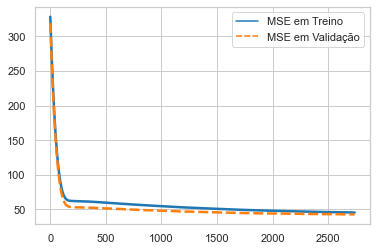

In [26]:
# Plot
sns.set(style = "whitegrid")
sns.lineplot(data = df, palette = "tab10", linewidth  = 2.5);

In [27]:
# Previsões com o modelo treinado
previsoes = modelo.predict(X_teste).flatten()

4/4 [==============================] - 0s 333us/step


In [30]:
previsoes

array([23.533716 , 25.995966 , 20.416304 , 21.00667  , 22.67697  ,
       22.547377 , 19.919535 , 21.791422 , 22.187399 , 20.733084 ,
       20.185919 , 20.567495 ,  9.876139 , 22.208994 , 18.436426 ,
       27.59427  , 19.667551 , 12.4751835, 34.037888 , 21.870615 ,
       22.266592 , 24.008886 , 18.472422 , 24.808039 , 20.581896 ,
       16.413347 , 19.631552 , 25.779982 , 20.250715 , 19.055586 ,
       17.457285 , 23.605715 , 29.991728 , 15.945375 , 20.560293 ,
       18.443624 , 29.070185 , 19.595552 , 20.999472 , 22.302591 ,
       16.14696  , 26.651129 , 35.182617 , 17.615671 , 23.540915 ,
       18.472422 , 18.38603  , 23.540915 , 21.741022 , 24.678446 ,
       20.60349  , 27.507875 , 21.561037 , 26.161558 , 31.122057 ,
       22.78496  , 22.1154   , 26.737524 , 23.339327 , 17.694868 ,
       26.024767 , 29.530954 , 24.512857 , 16.622133 , 24.707247 ,
       15.815783 , 23.929693 , 22.712965 , 24.82244  , 20.365908 ,
       18.997988 , 25.938372 , 19.487562 , 20.077925 , 21.5466